
# Olist – Business Analysis (Gold Layer, Python)

This notebook builds visuals from your **BigQuery Gold** layer to support three business conclusions:
1. **Logistics bottlenecks**
2. **Regional concentration of demand**
3. **Limited repeat customers**


## 0) Setup

In [7]:

PROJECT_ID = "olist-project-470402"   # your GCP project ID
DATASET_GOLD = "olist_gold"
OUTPUT_DIR = "outputs"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

client = bigquery.Client(project=PROJECT_ID)

def bq(sql: str) -> pd.DataFrame:
    return client.query(sql).result().to_dataframe()


In [8]:

FCT_ORDER_ITEM = f"`{PROJECT_ID}.{DATASET_GOLD}.fct_order_item`"
DIM_CUSTOMER   = f"`{PROJECT_ID}.{DATASET_GOLD}.dim_customer`"
DIM_SELLER     = f"`{PROJECT_ID}.{DATASET_GOLD}.dim_seller`"
DIM_ZIP        = f"`{PROJECT_ID}.{DATASET_GOLD}.dim_zip_prefix`"


## 1) Logistics bottlenecks – Late delivery by state

In [9]:

sql = f"""
SELECT
  dc.state,
  AVG(CAST(foi.late_delivery_flag AS FLOAT64)) AS late_rate,
  COUNT(*) AS items
FROM {FCT_ORDER_ITEM} foi
LEFT JOIN {DIM_CUSTOMER} dc
  ON foi.customer_key = dc.customer_key
WHERE foi.canceled_flag IS NULL OR foi.canceled_flag = 0
GROUP BY dc.state
HAVING items > 100
ORDER BY late_rate DESC
"""
df_late = bq(sql)
df_late.head()


/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,state,late_rate,items
0,AL,0.231982,444
1,MA,0.198780,820
2,SE,0.158442,385
3,PI,0.150278,539
4,CE,0.147897,1474


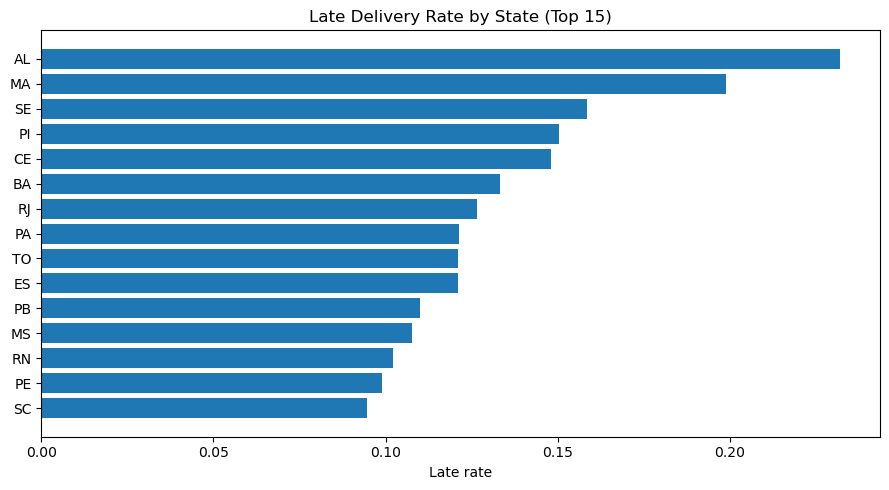

In [5]:

plt.figure(figsize=(9,5))
plt.barh(df_late["state"].head(15), df_late["late_rate"].head(15))
plt.gca().invert_yaxis()
plt.title("Late Delivery Rate by State (Top 15)")
plt.xlabel("Late rate")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/late_rate_by_state.png", dpi=150)
plt.show()


## 2) Limited repeat customers – Orders per customer distribution

In [10]:

sql = f"""
WITH per_order AS (
  SELECT DISTINCT order_id, customer_key
  FROM {FCT_ORDER_ITEM}
),
counts AS (
  SELECT customer_key, COUNT(*) AS orders
  FROM per_order
  GROUP BY customer_key
)
SELECT
  orders,
  COUNT(*) AS customers
FROM counts
GROUP BY orders
ORDER BY orders
"""
df_orders = bq(sql)
df_orders.head()


/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,orders,customers
0,1,98666


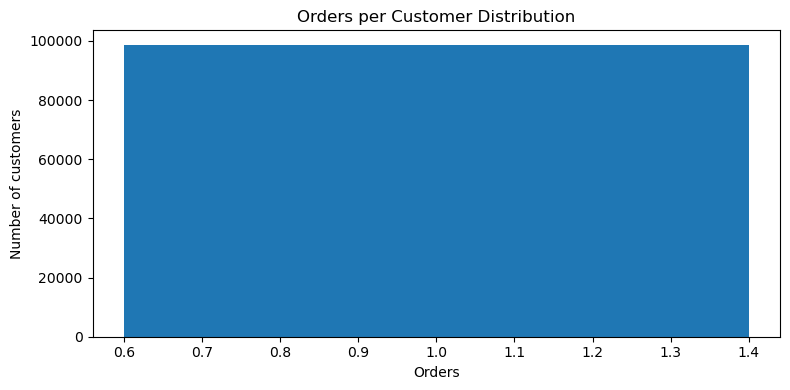

In [11]:

plt.figure(figsize=(8,4))
plt.bar(df_orders["orders"], df_orders["customers"])
plt.title("Orders per Customer Distribution")
plt.xlabel("Orders")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/orders_per_customer.png", dpi=150)
plt.show()



## Summary
- **Logistics bottlenecks** can be spotted by late delivery hot-spots.
- **Regional concentration** can be added using revenue by state or ZIP.
- **Repeat customers** are limited → retention programs should be considered.


## 3) Regional Revenue Concentration – Pareto & Map Bubbles

### 3.1 Revenue by State (Pareto and HHI)

In [12]:

# Revenue by state and concentration metrics
sql_revenue_by_state = f"""
WITH joined AS (
  SELECT
    dc.state AS state,
    foi.price + foi.freight_value AS revenue
  FROM {FCT_ORDER_ITEM} foi
  LEFT JOIN {DIM_CUSTOMER} dc
    ON foi.customer_key = dc.customer_key
  WHERE foi.canceled_flag = 0 OR foi.canceled_flag IS NULL
)
SELECT state, SUM(revenue) AS revenue
FROM joined
GROUP BY state
ORDER BY revenue DESC
"""
rev_state = bq(sql_revenue_by_state)

# Compute shares and cumulative share for Pareto
rev_state["share"] = rev_state["revenue"] / rev_state["revenue"].sum()
rev_state["cum_share"] = rev_state["share"].cumsum()

# Herfindahl-Hirschman Index (HHI) as concentration metric
hhi = float((rev_state["share"]**2).sum())

rev_state.to_csv(f"{OUTPUT_DIR}/revenue_by_state.csv", index=False)
print("HHI (0-1, higher = more concentrated):", round(hhi, 4))
rev_state.head()


/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


HHI (0-1, higher = more concentrated): 0.1828


,state,revenue,share,cum_share
0,SP,5878132.060000000,0.3735580034143921520752520991,0.3735580034143921520752520991
1,RJ,2115667.560000000,0.1344516491863571219705120992,0.5080096526007492740457641983
2,MG,1843074.430000000,0.1171282300545862301505639497,0.6251378826553355041963281480
3,RS,877290.590000000,0.05575222160194783129548600826,0.6808901042572833354918141563
4,PR,794196.610000000,0.05047156084990691284141882345,0.7313616651071902483332329798


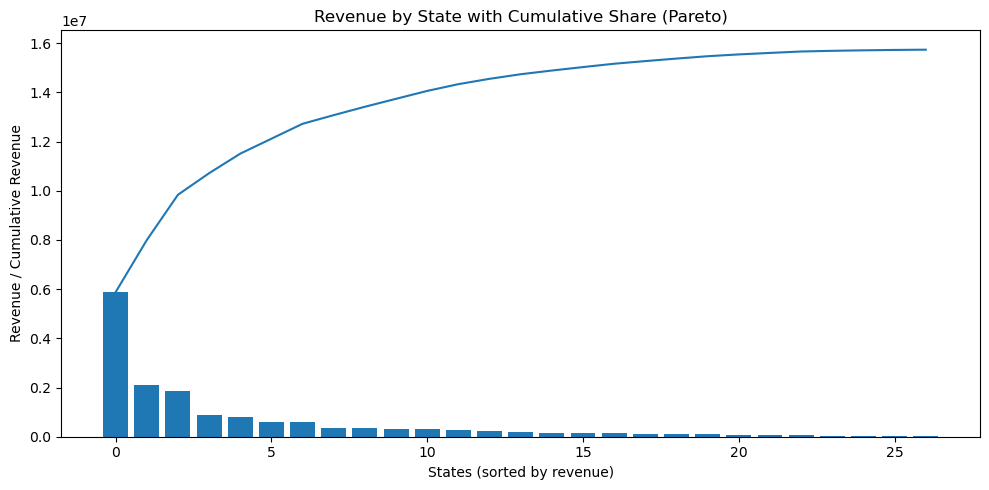

In [13]:

# Pareto chart: revenue by state with cumulative revenue line
import numpy as np
plt.figure(figsize=(10,5))

x = np.arange(len(rev_state))
# Bars: revenue by state
plt.bar(x, rev_state["revenue"])
# Line: cumulative revenue (scaled to revenue axis)
plt.plot(x, rev_state["cum_share"] * rev_state["revenue"].sum())

plt.title("Revenue by State with Cumulative Share (Pareto)")
plt.xlabel("States (sorted by revenue)")
plt.ylabel("Revenue / Cumulative Revenue")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pareto_revenue_by_state.png", dpi=150)
plt.show()


In [14]:
# A. What columns are in dim_zip_prefix right now?
bq(f"""
SELECT column_name
FROM `{PROJECT_ID}.{DATASET_GOLD}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'dim_zip_prefix'
ORDER BY column_name
""")

/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,column_name
0,city
1,lat
2,lng
3,state
4,zip_prefix_key


In [15]:
# B. Sample a few rows to see column values (esp. state/lat/lng)
bq(f"""
SELECT *
FROM `{PROJECT_ID}.{DATASET_GOLD}.dim_zip_prefix`
LIMIT 5
""")

/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,zip_prefix_key,city,state,lat,lng
0,69931,capixaba,AC,-10.571230,-67.674421
1,69928,placido de castro,AC,-10.328657,-67.183065
2,69901,rio branco,AC,-9.959352,-67.805481
3,57260,limoeiro de anadia,AL,-9.625270,-36.022425
4,57073,maceio,AL,-9.558743,-35.760724


In [25]:
sql_state_bubbles = f"""
WITH rev AS (
  SELECT
    dc.state AS state,
    SUM(foi.price + foi.freight_value) AS revenue
  FROM {FCT_ORDER_ITEM} foi
  LEFT JOIN {DIM_CUSTOMER} dc
    ON foi.customer_key = dc.customer_key
  WHERE COALESCE(CAST(foi.canceled_flag AS STRING), '') IN ('', '0', 'false', 'False', 'FALSE')
    AND dc.state IS NOT NULL
  GROUP BY dc.state
),
centroids AS (
  SELECT
    state,
    AVG(lat) AS lat,
    AVG(lng) AS lng
  FROM {DIM_ZIP}
  WHERE state IS NOT NULL AND lat IS NOT NULL AND lng IS NOT NULL
  GROUP BY state
)
SELECT
  c.lat,
  c.lng,
  r.revenue
FROM rev r
JOIN centroids c
  ON r.state = c.state
ORDER BY r.revenue DESC
"""
print(sql_state_bubbles)
zip_bubbles = bq(sql_state_bubbles)
zip_bubbles.head()


WITH rev AS (
  SELECT
    dc.state AS state,
    SUM(foi.price + foi.freight_value) AS revenue
  FROM `olist-project-470402.olist_gold.fct_order_item` foi
  LEFT JOIN `olist-project-470402.olist_gold.dim_customer` dc
    ON foi.customer_key = dc.customer_key
  WHERE COALESCE(CAST(foi.canceled_flag AS STRING), '') IN ('', '0', 'false', 'False', 'FALSE')
    AND dc.state IS NOT NULL
  GROUP BY dc.state
),
centroids AS (
  SELECT
    state,
    AVG(lat) AS lat,
    AVG(lng) AS lng
  FROM `olist-project-470402.olist_gold.dim_zip_prefix`
  WHERE state IS NOT NULL AND lat IS NOT NULL AND lng IS NOT NULL
  GROUP BY state
)
SELECT
  c.lat,
  c.lng,
  r.revenue
FROM rev r
JOIN centroids c
  ON r.state = c.state
ORDER BY r.revenue DESC



/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,lat,lng,revenue
0,-23.191158,-47.053785,5878132.060000000
1,-22.623133,-43.189515,2115667.560000000
2,-19.768132,-44.253586,1843074.430000000
3,-29.405372,-51.995458,877290.590000000
4,-24.517617,-51.139214,794196.610000000


### 3.2 ZIP-level Revenue Bubbles (no basemap)

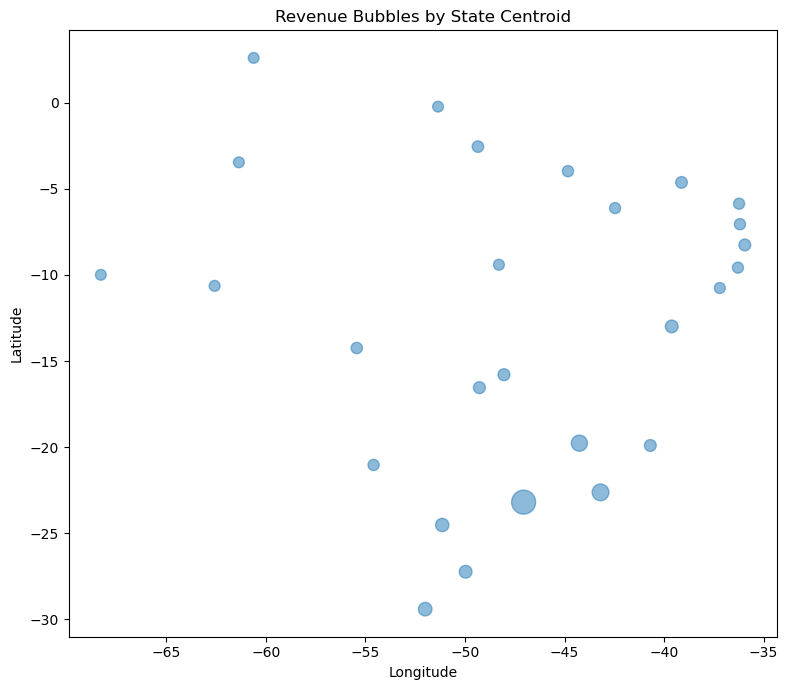

Plotted 27 points.


In [28]:
# --- Robust bubble scatter (ensure equal-length numeric arrays) ---

# 1) Coerce columns to numeric and drop bad rows
plot_df = zip_bubbles.copy()

for col in ["lng", "lat", "revenue"]:
    plot_df[col] = pd.to_numeric(plot_df[col], errors="coerce")

plot_df = plot_df.dropna(subset=["lng", "lat", "revenue"]).reset_index(drop=True)

# Guard: nothing to plot
if plot_df.empty:
    print("No rows to plot after cleaning (check upstream query/filters).")
else:
    x = plot_df["lng"]
    y = plot_df["lat"]
    svals = plot_df["revenue"]

    # 2) Normalize sizes to a readable range [60, 300] pts^2
    smin, smax = float(svals.min()), float(svals.max())
    if smax == smin:
        sizes = np.full(len(svals), 120.0)  # constant size if all equal
    else:
        sizes = 60.0 + 240.0 * (svals - smin) / (smax - smin)

    # 3) Plot
    plt.figure(figsize=(8,7))
    plt.scatter(x, y, s=sizes, alpha=0.5)
    plt.title("Revenue Bubbles by State Centroid")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/state_revenue_bubbles.png", dpi=150)
    plt.show()

    print(f"Plotted {len(plot_df)} points.")

In [2]:
import sys
print(sys.executable)

/opt/anaconda3/envs/pds/bin/python


In [3]:
import folium
print(folium.__version__)

0.20.0


In [16]:
sql_state_bubbles = f"""
WITH rev AS (
  SELECT
    dc.state AS state,
    SUM(foi.price + foi.freight_value) AS revenue
  FROM {FCT_ORDER_ITEM} foi
  LEFT JOIN {DIM_CUSTOMER} dc
    ON foi.customer_key = dc.customer_key
  WHERE COALESCE(CAST(foi.canceled_flag AS STRING), '') IN ('', '0', 'false', 'False', 'FALSE')
    AND dc.state IS NOT NULL
  GROUP BY dc.state
),
centroids AS (
  SELECT
    state,
    AVG(lat) AS lat,
    AVG(lng) AS lng
  FROM {DIM_ZIP}
  WHERE state IS NOT NULL AND lat IS NOT NULL AND lng IS NOT NULL
  GROUP BY state
)
SELECT
  c.lat,
  c.lng,
  r.revenue
FROM rev r
JOIN centroids c
  ON r.state = c.state
ORDER BY r.revenue DESC
"""

zip_bubbles = bq(sql_state_bubbles)
zip_bubbles.head()

/opt/anaconda3/envs/pds/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,lat,lng,revenue
0,-23.191158,-47.053785,5878132.060000000
1,-22.623133,-43.189515,2115667.560000000
2,-19.768132,-44.253586,1843074.430000000
3,-29.405372,-51.995458,877290.590000000
4,-24.517617,-51.139214,794196.610000000


In [17]:
# ---- 4) Folium interactive map ----
# If folium isn't installed in this kernel:  !{sys.executable} -m pip install folium
import folium

# Center map on the data centroid
center_lat = float(zip_bubbles["lat"].mean())
center_lng = float(zip_bubbles["lng"].mean())

m = folium.Map(location=[center_lat, center_lng], zoom_start=4, tiles="OpenStreetMap")

# Scale bubble radii to a readable range
rev = zip_bubbles["revenue"].astype(float)
min_s, max_s = 4, 25
sizes = min_s + (rev - rev.min()) / (rev.max() - rev.min() + 1e-9) * (max_s - min_s)

for (_, row), r in zip(zip_bubbles.iterrows(), sizes):
    folium.CircleMarker(
        location=[float(row["lat"]), float(row["lng"])],
        radius=float(r),
        fill=True,
        fill_opacity=0.5,
        opacity=0.6,
        popup=folium.Popup(f"Revenue: {row['revenue']:.2f}", max_width=250),
    ).add_to(m)

m.save(f"{OUTPUT_DIR}/state_revenue_bubbles_map.html")
m